In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import datetime

from sklearn.linear_model import LogisticRegression
import sklearn.metrics
from sklearn.preprocessing import PolynomialFeatures

from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [2]:
folder_dir = '../data/'
date_range = ["2012","2013","2014","2015","2016","2017"]

In [3]:
for i in range(len(date_range)):
    year = date_range[i]
    data_path = "MLB_" + year + "/MLB_PitchFX_" + year + "_RegularSeason.csv"
    year_data = pd.read_csv(filepath_or_buffer= folder_dir + data_path, header=0)
    
    if i == 0:
        data = year_data
    else:
        data = pd.concat([data,year_data])

data.head()

date       stadium  inning side    pitcher  pitch_count     batter  \
0  2012-04-04  Marlins Park       1  top  johnsjo09            5  beltrca01   
1  2012-04-04  Marlins Park       1  top  johnsjo09            6  hollima01   
2  2012-04-04  Marlins Park       1  top  johnsjo09            7  hollima01   
3  2012-04-04  Marlins Park       1  top  johnsjo09            8  hollima01   
4  2012-04-04  Marlins Park       1  top  johnsjo09            9  hollima01   

   balls  strikes      ay      ...        break_length       y     x0  \
0      0        0  30.626      ...                 3.4  154.56 -1.902   
1      0        0  28.580      ...                 3.8  132.11 -2.052   
2      0        1  31.294      ...                 3.7  125.20 -2.130   
3      0        2  33.548      ...                 3.6  151.97 -2.100   
4      1        2  24.925      ...                 7.1  144.20 -2.312   

       on_1b  on_2b  on_3b  umpcall  outcome  offense_score  defense_score  
0        NaN    NaN    NaN        X   Single              0              0  
1  beltrca01    NaN    NaN        S      NaN              0              0  
2  beltrca01    NaN    NaN        S      NaN              0              0  
3  beltrca01    NaN    NaN        B      NaN              0              0  
4  beltrca01    NaN    NaN        X   Flyout              0              0  

[5 rows x 47 columns]

In [4]:
'''
TODO:
    -More exploratory data analysis
    -Feature engineering/Clean data/select features
    -Define target valuable   
    
'''

'\nTODO:\n    -More exploratory data analysis\n    -Feature engineering/Clean data/select features\n    -Define target valuable   \n    \n'

In [5]:
data = data.drop(['on_1b', 'on_2b', "on_3b",'y'], axis = 1)
data.shape

(3902210, 43)

Drop pitches well outside the strike zone (https://www.fangraphs.com/tht/tht-annual-2018/using-movement-velocity-location-to-predict-a-swinging-strike/)

In [6]:
data.shape

(3902210, 43)

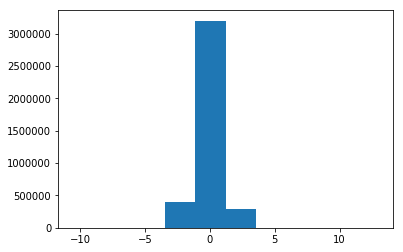

In [7]:
plt.hist(data['px']);

In [8]:
data=data[(data['px']<=2) | (data['px']>=-2)]
data=data[(data['pz']<=5) | (data['pz']>=0)]
#df= df[df["score"] > 50]
#data=data.loc[5<=data['pz']<=50]
data.shape

(3902210, 43)

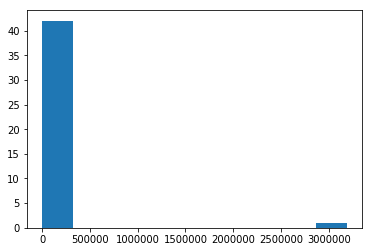

In [9]:
_ = plt.hist(data.isnull().sum())

In [10]:
print(len(data.columns.values))
print(data.columns.values[0])
data.columns.values

43
date


array(['date', 'stadium', 'inning', 'side', 'pitcher', 'pitch_count',
       'batter', 'balls', 'strikes', 'ay', 'px', 'ax', 'sz_bot', 'vz0',
       'vy0', 'pfx_x', 'type_confidence', 'z0', 'tfs', 'pz', 'start_speed',
       'az', 'zone', 'break_angle', 'spin_dir', 'end_speed', 'vx0',
       'sz_top', 'nasty', 'descr', 'pfx_z', 'break_y', 'pitch_type',
       'tfs_zulu', 'x', 'spin_rate', 'y0', 'break_length', 'x0', 'umpcall',
       'outcome', 'offense_score', 'defense_score'], dtype=object)

In [11]:
data.isnull().sum()

date                     0
stadium                  0
inning                   0
side                     0
pitcher                313
pitch_count              0
batter                   5
balls                    0
strikes                  0
ay                       0
px                       0
ax                       0
sz_bot                   0
vz0                      0
vy0                      0
pfx_x                    0
type_confidence          0
z0                       0
tfs                     29
pz                       0
start_speed              0
az                       0
zone                     0
break_angle              0
spin_dir                 0
end_speed                0
vx0                      0
sz_top                   0
nasty                  317
descr                    0
pfx_z                    0
break_y                  0
pitch_type               0
tfs_zulu                29
x                        0
spin_rate                0
y0                       0
b

In [12]:
data.dtypes

date                object
stadium             object
inning               int64
side                object
pitcher             object
pitch_count          int64
batter              object
balls                int64
strikes              int64
ay                 float64
px                 float64
ax                 float64
sz_bot             float64
vz0                float64
vy0                float64
pfx_x              float64
type_confidence    float64
z0                 float64
tfs                float64
pz                 float64
start_speed        float64
az                 float64
zone                 int64
break_angle        float64
spin_dir           float64
end_speed          float64
vx0                float64
sz_top             float64
nasty              float64
descr               object
pfx_z              float64
break_y            float64
pitch_type          object
tfs_zulu            object
x                  float64
spin_rate          float64
y0                 float64
b

### Finding feature types

In [13]:
g = data.columns.to_series().groupby(data.dtypes).groups
dtype_groups = {k.name: v for k, v in g.items()}
dtype_groups

{'float64': Index(['ay', 'px', 'ax', 'sz_bot', 'vz0', 'vy0', 'pfx_x', 'type_confidence',
        'z0', 'tfs', 'pz', 'start_speed', 'az', 'break_angle', 'spin_dir',
        'end_speed', 'vx0', 'sz_top', 'nasty', 'pfx_z', 'break_y', 'x',
        'spin_rate', 'y0', 'break_length', 'x0'],
       dtype='object'),
 'int64': Index(['inning', 'pitch_count', 'balls', 'strikes', 'zone', 'offense_score',
        'defense_score'],
       dtype='object'),
 'object': Index(['date', 'stadium', 'side', 'pitcher', 'batter', 'descr', 'pitch_type',
        'tfs_zulu', 'umpcall', 'outcome'],
       dtype='object')}

In [14]:
dtype_groups["int64"].values

array(['inning', 'pitch_count', 'balls', 'strikes', 'zone',
       'offense_score', 'defense_score'], dtype=object)

In [15]:
dtype_groups["float64"].values

array(['ay', 'px', 'ax', 'sz_bot', 'vz0', 'vy0', 'pfx_x',
       'type_confidence', 'z0', 'tfs', 'pz', 'start_speed', 'az',
       'break_angle', 'spin_dir', 'end_speed', 'vx0', 'sz_top', 'nasty',
       'pfx_z', 'break_y', 'x', 'spin_rate', 'y0', 'break_length', 'x0'], dtype=object)

In [16]:
dtype_groups["object"].values

array(['date', 'stadium', 'side', 'pitcher', 'batter', 'descr',
       'pitch_type', 'tfs_zulu', 'umpcall', 'outcome'], dtype=object)

### Analyze the index

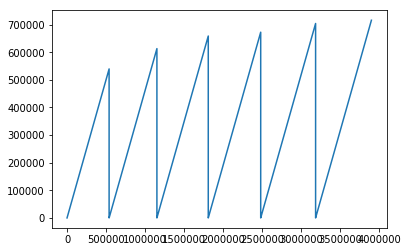

In [17]:
_ = plt.plot(data.index)

### Converting "date" feature to datetime

In [18]:
data["date"]

0         2012-04-04
1         2012-04-04
2         2012-04-04
3         2012-04-04
4         2012-04-04
5         2012-04-04
6         2012-04-04
7         2012-04-04
8         2012-04-04
9         2012-04-04
10        2012-04-04
11        2012-04-04
12        2012-04-04
13        2012-04-04
14        2012-04-04
15        2012-04-04
16        2012-04-04
17        2012-04-04
18        2012-04-04
19        2012-04-04
20        2012-04-04
21        2012-04-04
22        2012-04-04
23        2012-04-04
24        2012-04-04
25        2012-04-04
26        2012-04-04
27        2012-04-04
28        2012-04-04
29        2012-04-04
             ...    
715507    2017-10-01
715508    2017-10-01
715509    2017-10-01
715510    2017-10-01
715511    2017-10-01
715512    2017-10-01
715513    2017-10-01
715514    2017-10-01
715515    2017-10-01
715516    2017-10-01
715517    2017-10-01
715518    2017-10-01
715519    2017-10-01
715520    2017-10-01
715521    2017-10-01
715522    2017-10-01
715523    201

In [19]:
data["date"][0:5]

0    2012-04-04
1    2012-04-04
2    2012-04-04
3    2012-04-04
4    2012-04-04
Name: date, dtype: object

In [20]:
pd.to_datetime(data["date"][0:5])

0   2012-04-04
1   2012-04-04
2   2012-04-04
3   2012-04-04
4   2012-04-04
Name: date, dtype: datetime64[ns]

In [21]:
data["date"] = pd.to_datetime(data["date"])

In [22]:
data["date"][0:5]

0   2012-04-04
1   2012-04-04
2   2012-04-04
3   2012-04-04
4   2012-04-04
Name: date, dtype: datetime64[ns]

### sorting by pitcher, date and pitch_count in that order and reset index

In [23]:
data = data.sort_values(by = ["pitcher","date", "pitch_count"])
data

date        stadium  inning    side    pitcher  pitch_count  \
516886 2012-09-27  Rogers Centre       8  bottom  aardsda01            1   
516887 2012-09-27  Rogers Centre       8  bottom  aardsda01            2   
516888 2012-09-27  Rogers Centre       8  bottom  aardsda01            3   
516889 2012-09-27  Rogers Centre       8  bottom  aardsda01            4   
516890 2012-09-27  Rogers Centre       8  bottom  aardsda01            5   
516891 2012-09-27  Rogers Centre       8  bottom  aardsda01            6   
516892 2012-09-27  Rogers Centre       8  bottom  aardsda01            7   
516893 2012-09-27  Rogers Centre       8  bottom  aardsda01            8   
516894 2012-09-27  Rogers Centre       8  bottom  aardsda01            9   
516895 2012-09-27  Rogers Centre       8  bottom  aardsda01           10   
516896 2012-09-27  Rogers Centre       8  bottom  aardsda01           11   
516897 2012-09-27  Rogers Centre       8  bottom  aardsda01           12   
516898 2012-09-27  Rogers Centre       8  bottom  aardsda01           13   
516899 2012-09-27  Rogers Centre       8  bottom  aardsda01           14   
516900 2012-09-27  Rogers Centre       8  bottom  aardsda01           15   
516901 2012-09-27  Rogers Centre       8  bottom  aardsda01           16   
516902 2012-09-27  Rogers Centre       8  bottom  aardsda01           17   
516903 2012-09-27  Rogers Centre       8  bottom  aardsda01           18   
516904 2012-09-27  Rogers Centre       8  bottom  aardsda01           19   
516905 2012-09-27  Rogers Centre       8  bottom  aardsda01           20   
516906 2012-09-27  Rogers Centre       8  bottom  aardsda01           21   
516907 2012-09-27  Rogers Centre       8  bottom  aardsda01           22   
516908 2012-09-27  Rogers Centre       8  bottom  aardsda01           23   
516909 2012-09-27  Rogers Centre       8  bottom  aardsda01           24   
225661 2013-06-08     Citi Field      12     top  aardsda01            8   
225662 2013-06-08     Citi Field      12     top  aardsda01            9   
225663 2013-06-08     Citi Field      12     top  aardsda01           10   
225664 2013-06-08     Citi Field      12     top  aardsda01           11   
225665 2013-06-08     Citi Field      12     top  aardsda01           12   
225666 2013-06-08     Citi Field      12     top  aardsda01           13   
...           ...            ...     ...     ...        ...          ...   
605504 2017-09-04     Citi Field       5  bottom        NaN            7   
605505 2017-09-04     Citi Field       5  bottom        NaN            8   
605506 2017-09-04     Citi Field       5  bottom        NaN            9   
605507 2017-09-04     Citi Field       5  bottom        NaN           10   
605508 2017-09-04     Citi Field       5  bottom        NaN           11   
605509 2017-09-04     Citi Field       5  bottom        NaN           12   
605510 2017-09-04     Citi Field       5  bottom        NaN           13   
605511 2017-09-04     Citi Field       5  bottom        NaN           14   
605512 2017-09-04     Citi Field       5  bottom        NaN           15   
605513 2017-09-04     Citi Field       5  bottom        NaN           16   
605514 2017-09-04     Citi Field       5  bottom        NaN           17   
605515 2017-09-04     Citi Field       5  bottom        NaN           18   
605516 2017-09-04     Citi Field       5  bottom        NaN           19   
605517 2017-09-04     Citi Field       5  bottom        NaN           20   
605518 2017-09-04     Citi Field       5  bottom        NaN           21   
605519 2017-09-04     Citi Field       5  bottom        NaN           22   
605520 2017-09-04     Citi Field       5  bottom        NaN           23   
605567 2017-09-04     Citi Field       6  bottom        NaN           24   
605568 2017-09-04     Citi Field       6  bottom        NaN           25   
605569 2017-09-04     Citi Field       6  bottom        NaN           26   
605570 2017-09-04     Citi Field       6  bottom        NaN  

In [24]:
data = data.reset_index(drop = True)
data

date        stadium  inning    side    pitcher  pitch_count  \
0       2012-09-27  Rogers Centre       8  bottom  aardsda01            1   
1       2012-09-27  Rogers Centre       8  bottom  aardsda01            2   
2       2012-09-27  Rogers Centre       8  bottom  aardsda01            3   
3       2012-09-27  Rogers Centre       8  bottom  aardsda01            4   
4       2012-09-27  Rogers Centre       8  bottom  aardsda01            5   
5       2012-09-27  Rogers Centre       8  bottom  aardsda01            6   
6       2012-09-27  Rogers Centre       8  bottom  aardsda01            7   
7       2012-09-27  Rogers Centre       8  bottom  aardsda01            8   
8       2012-09-27  Rogers Centre       8  bottom  aardsda01            9   
9       2012-09-27  Rogers Centre       8  bottom  aardsda01           10   
10      2012-09-27  Rogers Centre       8  bottom  aardsda01           11   
11      2012-09-27  Rogers Centre       8  bottom  aardsda01           12   
12      2012-09-27  Rogers Centre       8  bottom  aardsda01           13   
13      2012-09-27  Rogers Centre       8  bottom  aardsda01           14   
14      2012-09-27  Rogers Centre       8  bottom  aardsda01           15   
15      2012-09-27  Rogers Centre       8  bottom  aardsda01           16   
16      2012-09-27  Rogers Centre       8  bottom  aardsda01           17   
17      2012-09-27  Rogers Centre       8  bottom  aardsda01           18   
18      2012-09-27  Rogers Centre       8  bottom  aardsda01           19   
19      2012-09-27  Rogers Centre       8  bottom  aardsda01           20   
20      2012-09-27  Rogers Centre       8  bottom  aardsda01           21   
21      2012-09-27  Rogers Centre       8  bottom  aardsda01           22   
22      2012-09-27  Rogers Centre       8  bottom  aardsda01           23   
23      2012-09-27  Rogers Centre       8  bottom  aardsda01           24   
24      2013-06-08     Citi Field      12     top  aardsda01            8   
25      2013-06-08     Citi Field      12     top  aardsda01            9   
26      2013-06-08     Citi Field      12     top  aardsda01           10   
27      2013-06-08     Citi Field      12     top  aardsda01           11   
28      2013-06-08     Citi Field      12     top  aardsda01           12   
29      2013-06-08     Citi Field      12     top  aardsda01           13   
...            ...            ...     ...     ...        ...          ...   
3902180 2017-09-04     Citi Field       5  bottom        NaN            7   
3902181 2017-09-04     Citi Field       5  bottom        NaN            8   
3902182 2017-09-04     Citi Field       5  bottom        NaN            9   
3902183 2017-09-04     Citi Field       5  bottom        NaN           10   
3902184 2017-09-04     Citi Field       5  bottom        NaN           11   
3902185 2017-09-04     Citi Field       5  bottom        NaN           12   
3902186 2017-09-04     Citi Field       5  bottom        NaN           13   
3902187 2017-09-04     Citi Field       5  bottom        NaN           14   
3902188 2017-09-04     Citi Field       5  bottom        NaN           15   
3902189 2017-09-04     Citi Field       5  bottom        NaN           16   
3902190 2017-09-04     Citi Field       5  bottom        NaN           17   
3902191 2017-09-04     Citi Field       5  bottom        NaN           18   
3902192 2017-09-04     Citi Field       5  bottom        NaN           19   
3902193 2017-09-04     Citi Field       5  bottom        NaN           20   
3902194 2017-09-04     Citi Field       5  bottom        NaN           21   
3902195 2017-09-04     Citi Field       5  bottom        NaN           22   
3902196 2017-09-04     Citi Field       5  bottom        NaN           23   
3902197 2017-09-04     Citi Field       6  bottom        NaN           24   
3902198 2017-09-04     Citi Field       6  bottom        NaN           25   
3902199 2017-09-04     Citi Field       6  bottom        NaN           26   
3902200 20

## 1. Target variable
We classify a pitch as good if it induces a swinging strike, a called strike, a foul, or if it generates a
ball in play that is converted to an out

In [25]:
data.outcome.unique()

array([nan, 'Groundout', 'Home Run', 'Forceout', 'Flyout', 'Pop Out',
       'Single', 'Grounded Into DP', 'Lineout', 'Double', 'Sac Bunt',
       'Sac Fly', 'Bunt Pop Out', 'Field Error', 'Double Play',
       'Fan interference', 'Triple', 'Fielders Choice', 'Bunt Groundout',
       'Fielders Choice Out', 'Sac Fly DP', 'Batter Interference',
       'Triple Play', 'Catcher Interference', 'Bunt Lineout',
       'Sacrifice Bunt DP', 'Fly Out', 'Reach on Error',
       'Pitcher Interference'], dtype=object)

In [26]:
data.umpcall.unique()

array(['S', 'B', 'X'], dtype=object)

In [27]:
data.descr.unique()

array(['Called Strike', 'Foul', 'Ball', 'In play, out(s)',
       'In play, run(s)', 'Swinging Strike', 'Swinging Strike (Blocked)',
       'Ball In Dirt', 'Foul Tip', 'In play, no out', 'Hit By Pitch',
       'Foul (Runner Going)', 'Foul Bunt', 'Missed Bunt'], dtype=object)

In [28]:
#Using descr feature to define good pitch
g_outcomes=['Foul Tip','Swinging Strike','In play, out(s)', 'Called Strike', 'Foul','Foul (Runner Going)','Foul Bunt',
       'Swinging Strike (Blocked)', 'Missed Bunt' ]

#Using outcome feature to use more detailed descriptions (eg: lineout vs groundout). I think this approach is better
g_outcomes2=['Flyout', 'Fly Out','Groundout','Pop Out','Forceout','Double Play','Grounded into DP','Fielders Choice','Fielders Choice Out', 
             'Bunt Groundout','Bunt Pop Out','Sac Fly DP','Bunt Lineout','Foul']

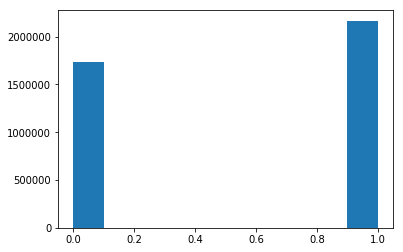

In [29]:
#Create target feature
data['y']=np.where((data['outcome'].isin(g_outcomes2)) | (data['umpcall']=='S'),1,0)
a=plt.hist(data['y'])

In [30]:
data.y.unique(), data.y.isnull().any()

(array([1, 0], dtype=int64), False)

In [31]:
data.columns

Index(['date', 'stadium', 'inning', 'side', 'pitcher', 'pitch_count', 'batter',
       'balls', 'strikes', 'ay', 'px', 'ax', 'sz_bot', 'vz0', 'vy0', 'pfx_x',
       'type_confidence', 'z0', 'tfs', 'pz', 'start_speed', 'az', 'zone',
       'break_angle', 'spin_dir', 'end_speed', 'vx0', 'sz_top', 'nasty',
       'descr', 'pfx_z', 'break_y', 'pitch_type', 'tfs_zulu', 'x', 'spin_rate',
       'y0', 'break_length', 'x0', 'umpcall', 'outcome', 'offense_score',
       'defense_score', 'y'],
      dtype='object')

In [32]:
data.dtypes

date               datetime64[ns]
stadium                    object
inning                      int64
side                       object
pitcher                    object
pitch_count                 int64
batter                     object
balls                       int64
strikes                     int64
ay                        float64
px                        float64
ax                        float64
sz_bot                    float64
vz0                       float64
vy0                       float64
pfx_x                     float64
type_confidence           float64
z0                        float64
tfs                       float64
pz                        float64
start_speed               float64
az                        float64
zone                        int64
break_angle               float64
spin_dir                  float64
end_speed                 float64
vx0                       float64
sz_top                    float64
nasty                     float64
descr         

# EDA

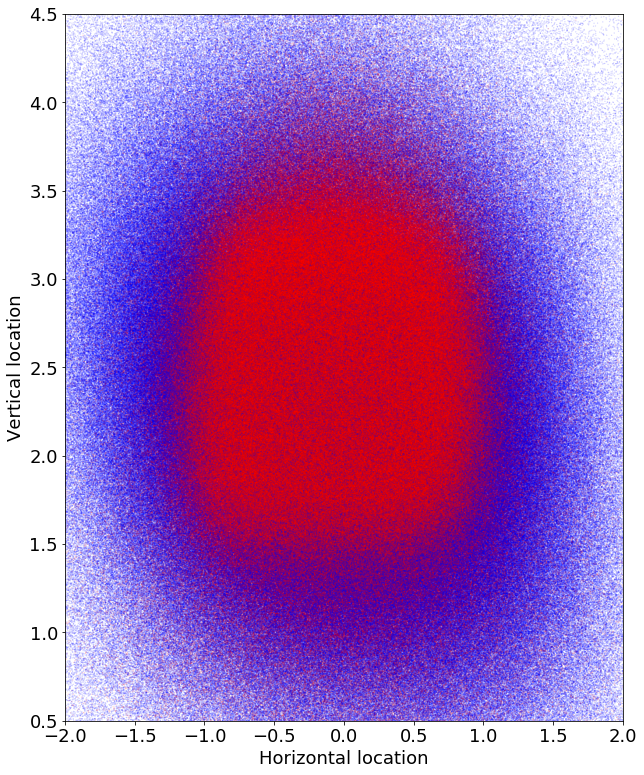

In [33]:
plt.figure(figsize=(10,13))
plt.xlim(-2,2)
plt.ylim(0.5,4.5)
plt.scatter(data['px'],data['pz'],s=.05, c=data['y'], alpha=0.3,cmap='bwr');
plt.xlabel('Horizontal location',fontsize=18)
plt.ylabel('Vertical location',fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.savefig('strike_zone.jpg', format='jpg', dpi=100)

In [34]:
a=pd.crosstab(data['y'], data['start_speed'].round(0), margins=True, normalize='columns')
a

start_speed  45.0      46.0  47.0      48.0  49.0  50.0  51.0  52.0      53.0  \
y                                                                               
0             0.8  0.333333  0.25  0.285714   0.6   1.0   0.0   0.5  0.666667   
1             0.2  0.666667  0.75  0.714286   0.4   0.0   1.0   0.5  0.333333   

start_speed      54.0    ...         97.0      98.0      99.0    100.0  \
y                        ...                                             
0            0.555556    ...     0.419724  0.417283  0.413173  0.40585   
1            0.444444    ...     0.580276  0.582717  0.586827  0.59415   

start_speed     101.0     102.0     103.0     104.0  105.0       All  
y                                                                     
0            0.407186  0.361511  0.354839  0.342857    0.5  0.445059  
1            0.592814  0.638489  0.645161  0.657143    0.5  0.554941  

[2 rows x 62 columns]

In [35]:
len(a.iloc[0][40:60])

20

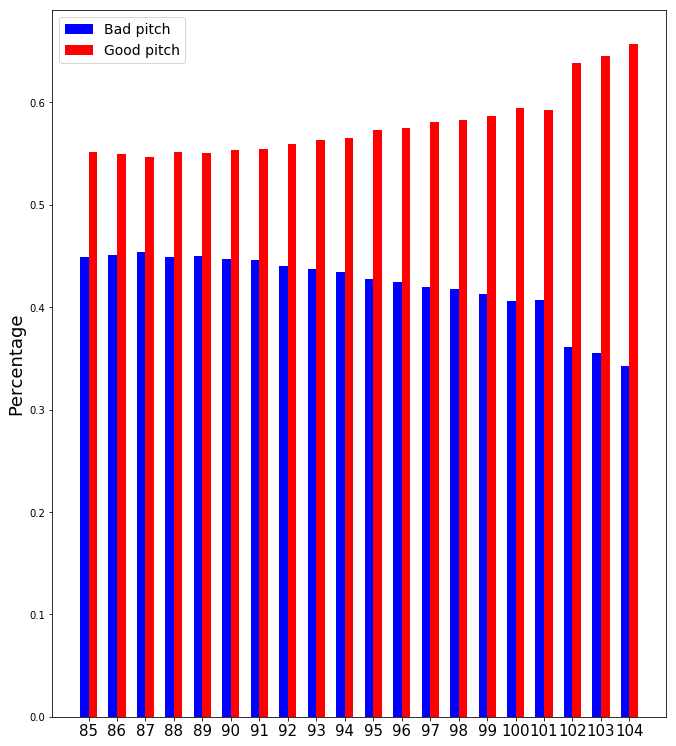

In [41]:
#By offense
plt.close('all')
fig, ax = plt.subplots(figsize=(11, 13))
ind = np.arange(1,21)
width=0.30

p1=ax.bar(ind,a.iloc[0][40:60], width, color='b')
p2=ax.bar(ind+width,a.iloc[1][40:60],width, color='r')

#ax.set_title('Parole granted/denied by type of offense')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels((range(85,105)),fontsize=15)
ax.legend((p1[0], p2[0]), ('Bad pitch', 'Good pitch'),fontsize=14)
plt.ylabel('Percentage',fontsize=18)
plt.savefig('pitch_velocities.jpg')
plt.show()

from pandas.plotting import scatter_matrix


scatter_matrix(data[['y','balls','strikes','spin_dir']], alpha=0.2, figsize=(6, 6), diagonal='kde')

In [37]:
data[['y','px','pz','pfx_x','pfx_z','start_speed',
      'spin_dir','pitch_count',
      'balls','strikes']].corr(method='pearson').round(3)

y     px     pz  pfx_x  pfx_z  start_speed  spin_dir  \
y            1.000 -0.011  0.091  0.003  0.021        0.021    -0.001   
px          -0.011  1.000 -0.133  0.176  0.014       -0.023    -0.170   
pz           0.091 -0.133  1.000 -0.039  0.233        0.237     0.061   
pfx_x        0.003  0.176 -0.039  1.000 -0.180       -0.276    -0.768   
pfx_z        0.021  0.014  0.233 -0.180  1.000        0.693     0.275   
start_speed  0.021 -0.023  0.237 -0.276  0.693        1.000     0.295   
spin_dir    -0.001 -0.170  0.061 -0.768  0.275        0.295     1.000   
pitch_count -0.003  0.001 -0.000  0.023 -0.049       -0.129    -0.023   
balls        0.068 -0.014  0.010 -0.020  0.061        0.081     0.030   
strikes     -0.015  0.029 -0.047  0.030 -0.095       -0.045    -0.033   

             pitch_count  balls  strikes  
y                 -0.003  0.068   -0.015  
px                 0.001 -0.014    0.029  
pz                -0.000  0.010   -0.047  
pfx_x              0.023 -0.020    0.030  
pfx_z             -0.049  0.061   -0.095  
start_speed       -0.129  0.081   -0.045  
spin_dir          -0.023  0.030   -0.033  
pitch_count        1.000  0.038    0.031  
balls              0.038  1.000    0.379  
strikes            0.031  0.379    1.000

#Plotting all Int64 typed features
for i in range(len(dtype_groups["int64"].values)):
    plt.figure(i, 
               figsize=(10,5))
    plt.title(dtype_groups["int64"].values[i])
    plt.hist(data[dtype_groups["int64"].values[i]],
             rwidth = 0.5)

#Plotting all Float64 typed features
for i in range(len(dtype_groups["float64"].values)):
    plt.figure(i, 
               figsize=(10,5))
    plt.title(dtype_groups["float64"].values[i])
    plt.hist(data[dtype_groups["float64"].values[i]].dropna(),
             rwidth = 0.5)

In [38]:
#_ = data[dtype_groups["object"][0]].value_counts().plot(kind="bar",
 #                                                   figsize=(20,10),
#                                                    title = "Dates")

#Plotting all Object typed features
for i in range(len(dtype_groups["object"].values)):
    print(dtype_groups["object"][i])
    _ = data[dtype_groups["object"][i]].value_counts().plot(kind="bar",
                                                       figsize=(20,10),
                                                       title = dtype_groups["object"][i])

(array([  273908.,   117352.,   197796.,   409078.,   174966.,   199062.,
          181744.,   522515.,   357548.,  1468241.]),
 array([  1. ,   2.3,   3.6,   4.9,   6.2,   7.5,   8.8,  10.1,  11.4,
         12.7,  14. ]),
 <a list of 10 Patch objects>)

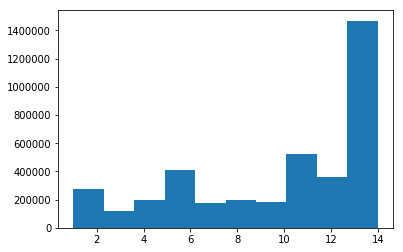

In [39]:
plt.hist(data['zone'])

(array([ 127781.,  222706.,  209657.,  570044.,  554273.,  963124.,
         906232.,  206608.,   76506.,   65279.]),
 array([ -2.00000000e-03,   3.59983000e+01,   7.19986000e+01,
          1.07998900e+02,   1.43999200e+02,   1.79999500e+02,
          2.15999800e+02,   2.52000100e+02,   2.88000400e+02,
          3.24000700e+02,   3.60001000e+02]),
 <a list of 10 Patch objects>)

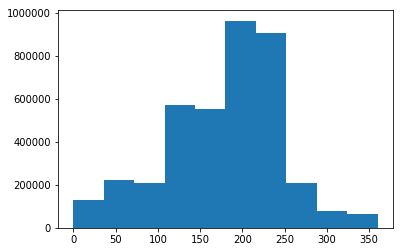

In [40]:
plt.hist(data['spin_dir'])

# Rolling_mean feature

In [41]:
#data = data.sample(n = 1000)
data.shape

(3902210, 44)

In [42]:
data.loc[data['pitch_type'] == "FF"]["start_speed"][0:5]

0    91.4
1    92.0
3    92.3
5    91.8
6    91.9
Name: start_speed, dtype: float64

In [76]:
roll_means = data.loc[data['pitch_type'] == "FF"].groupby('pitcher')['start_speed'].rolling(5).mean()
roll_means

pitcher           
aardsda01  0            NaN
           1            NaN
           3            NaN
           5            NaN
           6          91.88
           9          91.82
           10         91.68
           11         91.34
           15         91.22
           16         91.10
           19         91.10
           20         91.18
           23         91.52
           24         91.36
           26         91.36
           28         91.50
           29         91.58
           30         91.62
           31         92.02
           32         92.26
           34         92.46
           37         92.20
           41         91.98
           42         92.04
           43         92.04
           46         91.82
           49         92.02
           52         91.90
           55         92.02
           56         91.72
                      ...  
zychto01   3901841    93.86
           3901842    93.76
           3901846    93.50
           3901848    93.48
 

check where the NaNs are to see if rolling averages use data from previous pitchers

In [77]:
roll_means.values

array([   nan,    nan,    nan, ...,  92.18,  92.48,  92.04])

In [78]:
nan_roll_means = pd.DataFrame(np.argwhere(np.isnan(roll_means.values)))
nan_roll_means

0
0           0
1           1
2           2
3           3
4         764
5         765
6         766
7         767
8        2051
9        2052
10       2053
11       2054
12       2887
13       2888
14       2889
15       2890
16       3268
17       3269
18       3270
19       3271
20       3529
21       3530
22       3531
23       3532
24       4168
25       4169
26       4170
27       4171
28       4221
29       4222
...       ...
5185  1324832
5186  1324833
5187  1324925
5188  1324926
5189  1324927
5190  1324928
5191  1325290
5192  1325291
5193  1325292
5194  1325293
5195  1325608
5196  1325609
5197  1325610
5198  1325611
5199  1325866
5200  1325867
5201  1325868
5202  1325869
5203  1326240
5204  1326241
5205  1326242
5206  1326243
5207  1326247
5208  1326248
5209  1326249
5210  1326250
5211  1334676
5212  1334677
5213  1334678
5214  1334679

[5215 rows x 1 columns]

It seems like rolling mean is not using values from previous pitchers.

Take only the numeric index and discard the pitcher index:

In [79]:
roll_means = pd.DataFrame(roll_means)
roll_means

start_speed
pitcher                       
aardsda01 0                NaN
          1                NaN
          3                NaN
          5                NaN
          6              91.88
          9              91.82
          10             91.68
          11             91.34
          15             91.22
          16             91.10
          19             91.10
          20             91.18
          23             91.52
          24             91.36
          26             91.36
          28             91.50
          29             91.58
          30             91.62
          31             92.02
          32             92.26
          34             92.46
          37             92.20
          41             91.98
          42             92.04
          43             92.04
          46             91.82
          49             92.02
          52             91.90
          55             92.02
          56             91.72
...                        ...
zychto01  3901841        93.86
          3901842        93.76
          3901846        93.50
          3901848        93.48
          3901849        93.80
          3901850        93.62
          3901852        93.64
          3901853        93.94
          3901855        93.74
          3901856        93.58
          3901857        93.64
          3901858        93.60
          3901859        93.44
          3901860        93.60
          3901862        93.64
          3901863        93.72
          3901866        93.12
          3901867        93.02
          3901870        92.60
          3901871        92.58
          3901874        92.38
          3901875        92.56
          3901876        92.08
          3901877        91.86
          3901879        92.10
          3901880        91.94
          3901881        91.76
          3901884        92.18
          3901886        92.48
          3901890        92.04

[1334993 rows x 1 columns]

In [80]:
roll_means.index.values

array([('aardsda01', 0), ('aardsda01', 1), ('aardsda01', 3), ...,
       ('zychto01', 3901884), ('zychto01', 3901886), ('zychto01', 3901890)], dtype=object)

In [81]:
roll_means = roll_means.reset_index()
roll_means.head()

pitcher  level_1  start_speed
0  aardsda01        0          NaN
1  aardsda01        1          NaN
2  aardsda01        3          NaN
3  aardsda01        5          NaN
4  aardsda01        6        91.88

In [82]:
roll_means = roll_means.drop("pitcher", axis = 1)
roll_means.head()

level_1  start_speed
0        0          NaN
1        1          NaN
2        3          NaN
3        5          NaN
4        6        91.88

In [83]:
roll_means.columns.values[1] = "rolling_start_speed"

In [84]:
roll_means

level_1  rolling_start_speed
0              0                  NaN
1              1                  NaN
2              3                  NaN
3              5                  NaN
4              6                91.88
5              9                91.82
6             10                91.68
7             11                91.34
8             15                91.22
9             16                91.10
10            19                91.10
11            20                91.18
12            23                91.52
13            24                91.36
14            26                91.36
15            28                91.50
16            29                91.58
17            30                91.62
18            31                92.02
19            32                92.26
20            34                92.46
21            37                92.20
22            41                91.98
23            42                92.04
24            43                92.04
25            46                91.82
26            49                92.02
27            52                91.90
28            55                92.02
29            56                91.72
...          ...                  ...
1334963  3901841                93.86
1334964  3901842                93.76
1334965  3901846                93.50
1334966  3901848                93.48
1334967  3901849                93.80
1334968  3901850                93.62
1334969  3901852                93.64
1334970  3901853                93.94
1334971  3901855                93.74
1334972  3901856                93.58
1334973  3901857                93.64
1334974  3901858                93.60
1334975  3901859                93.44
1334976  3901860                93.60
1334977  3901862                93.64
1334978  3901863                93.72
1334979  3901866                93.12
1334980  3901867                93.02
1334981  3901870                92.60
1334982  3901871                92.58
1334983  3901874                92.38
1334984  3901875                92.56
1334985  3901876                92.08
1334986  3901877                91.86
1334987  3901879                92.10
1334988  3901880                91.94
1334989  3901881                91.76
1334990  3901884                92.18
1334991  3901886                92.48
1334992  3901890                92.04

[1334993 rows x 2 columns]

In [85]:
roll_means = roll_means.set_index("level_1")
roll_means.head()

rolling_start_speed
level_1                     
0                        NaN
1                        NaN
3                        NaN
5                        NaN
6                      91.88

In [86]:
data = pd.concat([data,roll_means], axis = 1)
data

date        stadium  inning    side    pitcher  pitch_count  \
0       2012-09-27  Rogers Centre       8  bottom  aardsda01            1   
1       2012-09-27  Rogers Centre       8  bottom  aardsda01            2   
2       2012-09-27  Rogers Centre       8  bottom  aardsda01            3   
3       2012-09-27  Rogers Centre       8  bottom  aardsda01            4   
4       2012-09-27  Rogers Centre       8  bottom  aardsda01            5   
5       2012-09-27  Rogers Centre       8  bottom  aardsda01            6   
6       2012-09-27  Rogers Centre       8  bottom  aardsda01            7   
7       2012-09-27  Rogers Centre       8  bottom  aardsda01            8   
8       2012-09-27  Rogers Centre       8  bottom  aardsda01            9   
9       2012-09-27  Rogers Centre       8  bottom  aardsda01           10   
10      2012-09-27  Rogers Centre       8  bottom  aardsda01           11   
11      2012-09-27  Rogers Centre       8  bottom  aardsda01           12   
12      2012-09-27  Rogers Centre       8  bottom  aardsda01           13   
13      2012-09-27  Rogers Centre       8  bottom  aardsda01           14   
14      2012-09-27  Rogers Centre       8  bottom  aardsda01           15   
15      2012-09-27  Rogers Centre       8  bottom  aardsda01           16   
16      2012-09-27  Rogers Centre       8  bottom  aardsda01           17   
17      2012-09-27  Rogers Centre       8  bottom  aardsda01           18   
18      2012-09-27  Rogers Centre       8  bottom  aardsda01           19   
19      2012-09-27  Rogers Centre       8  bottom  aardsda01           20   
20      2012-09-27  Rogers Centre       8  bottom  aardsda01           21   
21      2012-09-27  Rogers Centre       8  bottom  aardsda01           22   
22      2012-09-27  Rogers Centre       8  bottom  aardsda01           23   
23      2012-09-27  Rogers Centre       8  bottom  aardsda01           24   
24      2013-06-08     Citi Field      12     top  aardsda01            8   
25      2013-06-08     Citi Field      12     top  aardsda01            9   
26      2013-06-08     Citi Field      12     top  aardsda01           10   
27      2013-06-08     Citi Field      12     top  aardsda01           11   
28      2013-06-08     Citi Field      12     top  aardsda01           12   
29      2013-06-08     Citi Field      12     top  aardsda01           13   
...            ...            ...     ...     ...        ...          ...   
3902180 2017-09-04     Citi Field       5  bottom        NaN            7   
3902181 2017-09-04     Citi Field       5  bottom        NaN            8   
3902182 2017-09-04     Citi Field       5  bottom        NaN            9   
3902183 2017-09-04     Citi Field       5  bottom        NaN           10   
3902184 2017-09-04     Citi Field       5  bottom        NaN           11   
3902185 2017-09-04     Citi Field       5  bottom        NaN           12   
3902186 2017-09-04     Citi Field       5  bottom        NaN           13   
3902187 2017-09-04     Citi Field       5  bottom        NaN           14   
3902188 2017-09-04     Citi Field       5  bottom        NaN           15   
3902189 2017-09-04     Citi Field       5  bottom        NaN           16   
3902190 2017-09-04     Citi Field       5  bottom        NaN           17   
3902191 2017-09-04     Citi Field       5  bottom        NaN           18   
3902192 2017-09-04     Citi Field       5  bottom        NaN           19   
3902193 2017-09-04     Citi Field       5  bottom        NaN           20   
3902194 2017-09-04     Citi Field       5  bottom        NaN           21   
3902195 2017-09-04     Citi Field       5  bottom        NaN           22   
3902196 2017-09-04     Citi Field       5  bottom        NaN           23   
3902197 2017-09-04     Citi Field       6  bottom        NaN           24   
3902198 2017-09-04     Citi Field       6  bottom        NaN           25   
3902199 2017-09-04     Citi Field       6  bottom        NaN           26   
3902200 20

Ok, now we have the rolling means in the data dataframe but there are NaNs in the beginning of rolling means for each pitcher and between fastballs. So pad NaNs with the last value and change each beginning sequence for each pitcher back to NaN (because they will be padded with the previous pitcher's end rolling mean)

Padding the NaNs to the futureeee!

In [87]:
padded_roll_means = data["rolling_start_speed"].fillna(method = "ffill")
padded_roll_means

0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
5            NaN
6          91.88
7          91.88
8          91.88
9          91.82
10         91.68
11         91.34
12         91.34
13         91.34
14         91.34
15         91.22
16         91.10
17         91.10
18         91.10
19         91.10
20         91.18
21         91.18
22         91.18
23         91.52
24         91.36
25         91.36
26         91.36
27         91.36
28         91.50
29         91.58
           ...  
3902180    92.04
3902181    92.04
3902182    92.04
3902183    92.04
3902184    92.04
3902185    92.04
3902186    92.04
3902187    92.04
3902188    92.04
3902189    92.04
3902190    92.04
3902191    92.04
3902192    92.04
3902193    92.04
3902194    92.04
3902195    92.04
3902196    92.04
3902197    92.04
3902198    92.04
3902199    92.04
3902200    92.04
3902201    92.04
3902202    92.04
3902203    92.04
3902204    92.04
3902205    92.04
3902206    92.04
3902207    92.

In [88]:
nan_roll_means.values.reshape(1,-1)[0]

array([      0,       1,       2, ..., 1334677, 1334678, 1334679])

In [89]:
len(nan_roll_means.values)

5215

In [90]:
padded_roll_means[nan_roll_means.values.reshape(1,-1)[0]]

0            NaN
1            NaN
2            NaN
3            NaN
764        91.78
765        91.88
766        91.64
767        91.64
2051       94.84
2052       94.84
2053       94.84
2054       94.78
2887       92.18
2888       92.18
2889       92.18
2890       92.18
3268       93.06
3269       93.06
3270       93.06
3271       93.06
3529       86.84
3530       86.84
3531       86.84
3532       86.84
4168       90.08
4169       90.08
4170       90.08
4171       90.08
4221       89.74
4222       89.74
           ...  
1324832    90.78
1324833    90.68
1324925    90.06
1324926    90.06
1324927    90.06
1324928    90.06
1325290    90.32
1325291    90.32
1325292    90.56
1325293    90.50
1325608    86.36
1325609    86.36
1325610    86.36
1325611    86.36
1325866    90.48
1325867    90.48
1325868    90.00
1325869    90.00
1326240    96.86
1326241    97.38
1326242    97.38
1326243    97.38
1326247    97.64
1326248    97.64
1326249    97.64
1326250    97.64
1334676    91.10
1334677    91.

In [91]:
padded_roll_means[nan_roll_means.values.reshape(1,-1)[0]] = np.nan
padded_roll_means[nan_roll_means.values.reshape(1,-1)[0]]

0         NaN
1         NaN
2         NaN
3         NaN
764       NaN
765       NaN
766       NaN
767       NaN
2051      NaN
2052      NaN
2053      NaN
2054      NaN
2887      NaN
2888      NaN
2889      NaN
2890      NaN
3268      NaN
3269      NaN
3270      NaN
3271      NaN
3529      NaN
3530      NaN
3531      NaN
3532      NaN
4168      NaN
4169      NaN
4170      NaN
4171      NaN
4221      NaN
4222      NaN
           ..
1324832   NaN
1324833   NaN
1324925   NaN
1324926   NaN
1324927   NaN
1324928   NaN
1325290   NaN
1325291   NaN
1325292   NaN
1325293   NaN
1325608   NaN
1325609   NaN
1325610   NaN
1325611   NaN
1325866   NaN
1325867   NaN
1325868   NaN
1325869   NaN
1326240   NaN
1326241   NaN
1326242   NaN
1326243   NaN
1326247   NaN
1326248   NaN
1326249   NaN
1326250   NaN
1334676   NaN
1334677   NaN
1334678   NaN
1334679   NaN
Name: rolling_start_speed, Length: 5215, dtype: float64

So changed the starting sequence of fastballs back to NaN

Replacing rolling means with the padded ones:

In [92]:
data["rolling_start_speed"] = padded_roll_means
data

date        stadium  inning    side    pitcher  pitch_count  \
0       2012-09-27  Rogers Centre       8  bottom  aardsda01            1   
1       2012-09-27  Rogers Centre       8  bottom  aardsda01            2   
2       2012-09-27  Rogers Centre       8  bottom  aardsda01            3   
3       2012-09-27  Rogers Centre       8  bottom  aardsda01            4   
4       2012-09-27  Rogers Centre       8  bottom  aardsda01            5   
5       2012-09-27  Rogers Centre       8  bottom  aardsda01            6   
6       2012-09-27  Rogers Centre       8  bottom  aardsda01            7   
7       2012-09-27  Rogers Centre       8  bottom  aardsda01            8   
8       2012-09-27  Rogers Centre       8  bottom  aardsda01            9   
9       2012-09-27  Rogers Centre       8  bottom  aardsda01           10   
10      2012-09-27  Rogers Centre       8  bottom  aardsda01           11   
11      2012-09-27  Rogers Centre       8  bottom  aardsda01           12   
12      2012-09-27  Rogers Centre       8  bottom  aardsda01           13   
13      2012-09-27  Rogers Centre       8  bottom  aardsda01           14   
14      2012-09-27  Rogers Centre       8  bottom  aardsda01           15   
15      2012-09-27  Rogers Centre       8  bottom  aardsda01           16   
16      2012-09-27  Rogers Centre       8  bottom  aardsda01           17   
17      2012-09-27  Rogers Centre       8  bottom  aardsda01           18   
18      2012-09-27  Rogers Centre       8  bottom  aardsda01           19   
19      2012-09-27  Rogers Centre       8  bottom  aardsda01           20   
20      2012-09-27  Rogers Centre       8  bottom  aardsda01           21   
21      2012-09-27  Rogers Centre       8  bottom  aardsda01           22   
22      2012-09-27  Rogers Centre       8  bottom  aardsda01           23   
23      2012-09-27  Rogers Centre       8  bottom  aardsda01           24   
24      2013-06-08     Citi Field      12     top  aardsda01            8   
25      2013-06-08     Citi Field      12     top  aardsda01            9   
26      2013-06-08     Citi Field      12     top  aardsda01           10   
27      2013-06-08     Citi Field      12     top  aardsda01           11   
28      2013-06-08     Citi Field      12     top  aardsda01           12   
29      2013-06-08     Citi Field      12     top  aardsda01           13   
...            ...            ...     ...     ...        ...          ...   
3902180 2017-09-04     Citi Field       5  bottom        NaN            7   
3902181 2017-09-04     Citi Field       5  bottom        NaN            8   
3902182 2017-09-04     Citi Field       5  bottom        NaN            9   
3902183 2017-09-04     Citi Field       5  bottom        NaN           10   
3902184 2017-09-04     Citi Field       5  bottom        NaN           11   
3902185 2017-09-04     Citi Field       5  bottom        NaN           12   
3902186 2017-09-04     Citi Field       5  bottom        NaN           13   
3902187 2017-09-04     Citi Field       5  bottom        NaN           14   
3902188 2017-09-04     Citi Field       5  bottom        NaN           15   
3902189 2017-09-04     Citi Field       5  bottom        NaN           16   
3902190 2017-09-04     Citi Field       5  bottom        NaN           17   
3902191 2017-09-04     Citi Field       5  bottom        NaN           18   
3902192 2017-09-04     Citi Field       5  bottom        NaN           19   
3902193 2017-09-04     Citi Field       5  bottom        NaN           20   
3902194 2017-09-04     Citi Field       5  bottom        NaN           21   
3902195 2017-09-04     Citi Field       5  bottom        NaN           22   
3902196 2017-09-04     Citi Field       5  bottom        NaN           23   
3902197 2017-09-04     Citi Field       6  bottom        NaN           24   
3902198 2017-09-04     Citi Field       6  bottom        NaN           25   
3902199 2017-09-04     Citi Field       6  bottom        NaN           26   
3902200 20

### Deleting rows with no pitchers

In [93]:
data["pitcher"].values

array(['aardsda01', 'aardsda01', 'aardsda01', ..., nan, nan, nan], dtype=object)

In [94]:
data["pitcher"].values[-1]

nan

In [95]:
type(data["pitcher"].values[-1])

float

In [96]:
import math

In [97]:
math.isnan(data["pitcher"].values[-1])

True

In [98]:
data["pitcher"] = data["pitcher"].astype("str")
data["pitcher"]

0          aardsda01
1          aardsda01
2          aardsda01
3          aardsda01
4          aardsda01
5          aardsda01
6          aardsda01
7          aardsda01
8          aardsda01
9          aardsda01
10         aardsda01
11         aardsda01
12         aardsda01
13         aardsda01
14         aardsda01
15         aardsda01
16         aardsda01
17         aardsda01
18         aardsda01
19         aardsda01
20         aardsda01
21         aardsda01
22         aardsda01
23         aardsda01
24         aardsda01
25         aardsda01
26         aardsda01
27         aardsda01
28         aardsda01
29         aardsda01
             ...    
3902180          nan
3902181          nan
3902182          nan
3902183          nan
3902184          nan
3902185          nan
3902186          nan
3902187          nan
3902188          nan
3902189          nan
3902190          nan
3902191          nan
3902192          nan
3902193          nan
3902194          nan
3902195          nan
3902196      

In [99]:
nan_pitchers = pd.DataFrame(np.argwhere(data["pitcher"] == "nan")).values
nan_pitchers = nan_pitchers.reshape(1,-1)[0]
nan_pitchers

array([3901897, 3901898, 3901899, 3901900, 3901901, 3901902, 3901903,
       3901904, 3901905, 3901906, 3901907, 3901908, 3901909, 3901910,
       3901911, 3901912, 3901913, 3901914, 3901915, 3901916, 3901917,
       3901918, 3901919, 3901920, 3901921, 3901922, 3901923, 3901924,
       3901925, 3901926, 3901927, 3901928, 3901929, 3901930, 3901931,
       3901932, 3901933, 3901934, 3901935, 3901936, 3901937, 3901938,
       3901939, 3901940, 3901941, 3901942, 3901943, 3901944, 3901945,
       3901946, 3901947, 3901948, 3901949, 3901950, 3901951, 3901952,
       3901953, 3901954, 3901955, 3901956, 3901957, 3901958, 3901959,
       3901960, 3901961, 3901962, 3901963, 3901964, 3901965, 3901966,
       3901967, 3901968, 3901969, 3901970, 3901971, 3901972, 3901973,
       3901974, 3901975, 3901976, 3901977, 3901978, 3901979, 3901980,
       3901981, 3901982, 3901983, 3901984, 3901985, 3901986, 3901987,
       3901988, 3901989, 3901990, 3901991, 3901992, 3901993, 3901994,
       3901995, 3901

In [100]:
data = data.drop(nan_pitchers)
data

date          stadium  inning    side    pitcher  pitch_count  \
0       2012-09-27    Rogers Centre       8  bottom  aardsda01            1   
1       2012-09-27    Rogers Centre       8  bottom  aardsda01            2   
2       2012-09-27    Rogers Centre       8  bottom  aardsda01            3   
3       2012-09-27    Rogers Centre       8  bottom  aardsda01            4   
4       2012-09-27    Rogers Centre       8  bottom  aardsda01            5   
5       2012-09-27    Rogers Centre       8  bottom  aardsda01            6   
6       2012-09-27    Rogers Centre       8  bottom  aardsda01            7   
7       2012-09-27    Rogers Centre       8  bottom  aardsda01            8   
8       2012-09-27    Rogers Centre       8  bottom  aardsda01            9   
9       2012-09-27    Rogers Centre       8  bottom  aardsda01           10   
10      2012-09-27    Rogers Centre       8  bottom  aardsda01           11   
11      2012-09-27    Rogers Centre       8  bottom  aardsda01           12   
12      2012-09-27    Rogers Centre       8  bottom  aardsda01           13   
13      2012-09-27    Rogers Centre       8  bottom  aardsda01           14   
14      2012-09-27    Rogers Centre       8  bottom  aardsda01           15   
15      2012-09-27    Rogers Centre       8  bottom  aardsda01           16   
16      2012-09-27    Rogers Centre       8  bottom  aardsda01           17   
17      2012-09-27    Rogers Centre       8  bottom  aardsda01           18   
18      2012-09-27    Rogers Centre       8  bottom  aardsda01           19   
19      2012-09-27    Rogers Centre       8  bottom  aardsda01           20   
20      2012-09-27    Rogers Centre       8  bottom  aardsda01           21   
21      2012-09-27    Rogers Centre       8  bottom  aardsda01           22   
22      2012-09-27    Rogers Centre       8  bottom  aardsda01           23   
23      2012-09-27    Rogers Centre       8  bottom  aardsda01           24   
24      2013-06-08       Citi Field      12     top  aardsda01            8   
25      2013-06-08       Citi Field      12     top  aardsda01            9   
26      2013-06-08       Citi Field      12     top  aardsda01           10   
27      2013-06-08       Citi Field      12     top  aardsda01           11   
28      2013-06-08       Citi Field      12     top  aardsda01           12   
29      2013-06-08       Citi Field      12     top  aardsda01           13   
...            ...              ...     ...     ...        ...          ...   
3901867 2017-08-12     Safeco Field       8     top   zychto01           20   
3901868 2017-08-12     Safeco Field       8     top   zychto01           21   
3901869 2017-08-12     Safeco Field       8     top   zychto01           22   
3901870 2017-08-12     Safeco Field       8     top   zychto01           23   
3901871 2017-08-12     Safeco Field       8     top   zychto01           24   
3901872 2017-08-12     Safeco Field       8     top   zychto01           25   
3901873 2017-08-12     Safeco Field       8     top   zychto01           26   
3901874 2017-08-16     Safeco Field       5     top   zychto01            1   
3901875 2017-08-16     Safeco Field       5     top   zychto01            2   
3901876 2017-08-16     Safeco Field       5     top   zychto01            3   
3901877 2017-08-16     Safeco Field       5     top   zychto01            4   
3901878 2017-08-16     Safeco Field       5     top   zychto01            5   
3901879 2017-08-16     Safeco Field       5     top   zychto01            6   
3901880 2017-08-16     Safeco Field       6     top   zychto01            7   
3901881 2017-08-16     Safeco Field       6     top   zychto01            8   
3901882 2017-08-16     Safeco Field       6     top   zychto01            9   
3901883 2017-08-16     Safeco Field       6     top   zychto01           10   
3901884 2017-08-16     Safeco Field       6     top   zychto01           11   
3901885 2017-08-16     Safeco Field       6     top   zychto01  

### Adding 20 pitch rolling mean

In [101]:
data.shape

(3901897, 45)

In [102]:
long_roll_means = data.loc[data['pitch_type'] == "FF"]\
                    .groupby('pitcher')['start_speed']\
                    .rolling(200).mean()

nan_longroll_means = pd.DataFrame(np.argwhere(np.isnan(long_roll_means.values)))

long_roll_means = pd.DataFrame(long_roll_means)
long_roll_means = long_roll_means.reset_index()
long_roll_means = long_roll_means.drop("pitcher", axis = 1)
long_roll_means.columns.values[1] = "long_rolling_start_speed"
long_roll_means = long_roll_means.set_index("level_1")



data = pd.concat([data,long_roll_means], axis = 1)
padded_long_roll_means = data["long_rolling_start_speed"].fillna(method = "ffill")
padded_long_roll_means[nan_longroll_means.values.reshape(1,-1)[0]] = np.nan
data["long_rolling_start_speed"] = padded_long_roll_means
data

date          stadium  inning    side    pitcher  pitch_count  \
0       2012-09-27    Rogers Centre       8  bottom  aardsda01            1   
1       2012-09-27    Rogers Centre       8  bottom  aardsda01            2   
2       2012-09-27    Rogers Centre       8  bottom  aardsda01            3   
3       2012-09-27    Rogers Centre       8  bottom  aardsda01            4   
4       2012-09-27    Rogers Centre       8  bottom  aardsda01            5   
5       2012-09-27    Rogers Centre       8  bottom  aardsda01            6   
6       2012-09-27    Rogers Centre       8  bottom  aardsda01            7   
7       2012-09-27    Rogers Centre       8  bottom  aardsda01            8   
8       2012-09-27    Rogers Centre       8  bottom  aardsda01            9   
9       2012-09-27    Rogers Centre       8  bottom  aardsda01           10   
10      2012-09-27    Rogers Centre       8  bottom  aardsda01           11   
11      2012-09-27    Rogers Centre       8  bottom  aardsda01           12   
12      2012-09-27    Rogers Centre       8  bottom  aardsda01           13   
13      2012-09-27    Rogers Centre       8  bottom  aardsda01           14   
14      2012-09-27    Rogers Centre       8  bottom  aardsda01           15   
15      2012-09-27    Rogers Centre       8  bottom  aardsda01           16   
16      2012-09-27    Rogers Centre       8  bottom  aardsda01           17   
17      2012-09-27    Rogers Centre       8  bottom  aardsda01           18   
18      2012-09-27    Rogers Centre       8  bottom  aardsda01           19   
19      2012-09-27    Rogers Centre       8  bottom  aardsda01           20   
20      2012-09-27    Rogers Centre       8  bottom  aardsda01           21   
21      2012-09-27    Rogers Centre       8  bottom  aardsda01           22   
22      2012-09-27    Rogers Centre       8  bottom  aardsda01           23   
23      2012-09-27    Rogers Centre       8  bottom  aardsda01           24   
24      2013-06-08       Citi Field      12     top  aardsda01            8   
25      2013-06-08       Citi Field      12     top  aardsda01            9   
26      2013-06-08       Citi Field      12     top  aardsda01           10   
27      2013-06-08       Citi Field      12     top  aardsda01           11   
28      2013-06-08       Citi Field      12     top  aardsda01           12   
29      2013-06-08       Citi Field      12     top  aardsda01           13   
...            ...              ...     ...     ...        ...          ...   
3901867 2017-08-12     Safeco Field       8     top   zychto01           20   
3901868 2017-08-12     Safeco Field       8     top   zychto01           21   
3901869 2017-08-12     Safeco Field       8     top   zychto01           22   
3901870 2017-08-12     Safeco Field       8     top   zychto01           23   
3901871 2017-08-12     Safeco Field       8     top   zychto01           24   
3901872 2017-08-12     Safeco Field       8     top   zychto01           25   
3901873 2017-08-12     Safeco Field       8     top   zychto01           26   
3901874 2017-08-16     Safeco Field       5     top   zychto01            1   
3901875 2017-08-16     Safeco Field       5     top   zychto01            2   
3901876 2017-08-16     Safeco Field       5     top   zychto01            3   
3901877 2017-08-16     Safeco Field       5     top   zychto01            4   
3901878 2017-08-16     Safeco Field       5     top   zychto01            5   
3901879 2017-08-16     Safeco Field       5     top   zychto01            6   
3901880 2017-08-16     Safeco Field       6     top   zychto01            7   
3901881 2017-08-16     Safeco Field       6     top   zychto01            8   
3901882 2017-08-16     Safeco Field       6     top   zychto01            9   
3901883 2017-08-16     Safeco Field       6     top   zychto01           10   
3901884 2017-08-16     Safeco Field       6     top   zychto01           11   
3901885 2017-08-16     Safeco Field       6     top   zychto01  

Check number of not nan rows in the long windowed rolling mean

In [103]:
len(np.argwhere(np.isnan(data["long_rolling_start_speed"])))

201448

In [104]:
data.shape

(3901897, 46)

### Deleting rows with NaN in long rolling mean column

In [105]:
np.argwhere(np.isnan(data["long_rolling_start_speed"])).reshape(1,-1)[0]

array([      0,       1,       2, ..., 1334872, 1334873, 1334874])

In [106]:
data = data.drop(np.argwhere(np.isnan(data["long_rolling_start_speed"])).reshape(1,-1)[0],
          axis = 0)
data

date          stadium  inning    side    pitcher  pitch_count  \
304     2013-07-19       Citi Field       8     top  aardsda01           10   
305     2013-07-19       Citi Field       8     top  aardsda01           11   
306     2013-07-19       Citi Field       8     top  aardsda01           12   
307     2013-07-19       Citi Field       8     top  aardsda01           13   
308     2013-07-19       Citi Field       9     top  aardsda01           14   
309     2013-07-19       Citi Field       9     top  aardsda01           15   
310     2013-07-19       Citi Field       9     top  aardsda01           16   
311     2013-07-19       Citi Field       9     top  aardsda01           17   
312     2013-07-19       Citi Field       9     top  aardsda01           18   
313     2013-07-19       Citi Field       9     top  aardsda01           19   
314     2013-07-19       Citi Field       9     top  aardsda01           20   
315     2013-07-19       Citi Field       9     top  aardsda01           21   
316     2013-07-19       Citi Field       9     top  aardsda01           22   
317     2013-07-19       Citi Field       9     top  aardsda01           23   
318     2013-07-19       Citi Field       9     top  aardsda01           24   
319     2013-07-19       Citi Field       9     top  aardsda01           25   
320     2013-07-19       Citi Field       9     top  aardsda01           26   
321     2013-07-19       Citi Field       9     top  aardsda01           27   
322     2013-07-19       Citi Field       9     top  aardsda01           28   
323     2013-07-23       Citi Field       7     top  aardsda01            1   
324     2013-07-23       Citi Field       7     top  aardsda01            2   
325     2013-07-23       Citi Field       7     top  aardsda01            3   
326     2013-07-23       Citi Field       7     top  aardsda01            4   
327     2013-07-23       Citi Field       7     top  aardsda01            5   
328     2013-07-23       Citi Field       7     top  aardsda01            6   
329     2013-07-23       Citi Field       7     top  aardsda01            7   
330     2013-07-23       Citi Field       7     top  aardsda01            8   
331     2013-07-23       Citi Field       7     top  aardsda01            9   
332     2013-07-23       Citi Field       7     top  aardsda01           10   
333     2013-07-25       Citi Field       7     top  aardsda01            1   
...            ...              ...     ...     ...        ...          ...   
3901867 2017-08-12     Safeco Field       8     top   zychto01           20   
3901868 2017-08-12     Safeco Field       8     top   zychto01           21   
3901869 2017-08-12     Safeco Field       8     top   zychto01           22   
3901870 2017-08-12     Safeco Field       8     top   zychto01           23   
3901871 2017-08-12     Safeco Field       8     top   zychto01           24   
3901872 2017-08-12     Safeco Field       8     top   zychto01           25   
3901873 2017-08-12     Safeco Field       8     top   zychto01           26   
3901874 2017-08-16     Safeco Field       5     top   zychto01            1   
3901875 2017-08-16     Safeco Field       5     top   zychto01            2   
3901876 2017-08-16     Safeco Field       5     top   zychto01            3   
3901877 2017-08-16     Safeco Field       5     top   zychto01            4   
3901878 2017-08-16     Safeco Field       5     top   zychto01            5   
3901879 2017-08-16     Safeco Field       5     top   zychto01            6   
3901880 2017-08-16     Safeco Field       6     top   zychto01            7   
3901881 2017-08-16     Safeco Field       6     top   zychto01            8   
3901882 2017-08-16     Safeco Field       6     top   zychto01            9   
3901883 2017-08-16     Safeco Field       6     top   zychto01           10   
3901884 2017-08-16     Safeco Field       6     top   zychto01           11   
3901885 2017-08-16     Safeco Field       6     top   zychto01  

## 3. Generate features: batter-pitcher_count, zones, regions(From RandomForest)

### Generate batter-pitcher count
##### https://twitter.com/darenw/status/985168614008508416 (cool image)

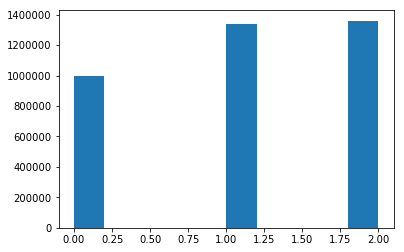

In [107]:
data['count_b_p']=np.where((data['strikes']>data['balls']),2,0)

data['count_b_p']=np.where(((data['strikes']==0) & (data['balls']==0)),
                           1,data['count_b_p'])
data['count_b_p']=np.where(((data['strikes']==1) & (data['balls']==1)),
                           1,data['count_b_p'])

# 2-2 is a pitchers' count
data['count_b_p']=np.where(((data['strikes']==2) & (data['balls']==2)),
                           2,data['count_b_p'])
plt.hist(data.count_b_p);

### One-hot encode zone

In [108]:
data['zone'].unique()

array([14,  4,  2, 11,  3,  7, 13,  1,  9,  5,  6,  8, 12])

In [109]:
zone=pd.get_dummies(data['zone'],prefix='zone').drop('zone_14',axis=1)
data=pd.concat([data,zone],axis=1).drop('zone',axis=1)

### Save data

In [110]:
#Drop columns we´re not going to use

data['year']=data['date'].dt.year

features=['date','umpcall', 'outcome','start_speed','pfx_x','pfx_z','px','pz','break_y','break_angle','break_length'
          ,'pitch_type','spin_dir','nasty','pitch_count','descr','y','year','count_b_p','strikes','balls','pitcher','pitch_type',
         'rolling_start_speed', 'long_rolling_start_speed','zone_1', 'zone_2', 'zone_3','zone_4', 'zone_5', 'zone_6',
          'zone_7', 'zone_8', 'zone_9', 'zone_11','zone_12', 'zone_13']

baseline_features=['start_speed','px','pz','year','y']

data=data[features]
#data_base=data[baseline_features]

In [111]:
#data_path = "MLB_" + year + "/MLB_PitchFX_" + year + "_RegularSeason.csv"
#year_data = pd.read_csv(filepath_or_buffer= folder_dir + data_path, header=0)
save_path=folder_dir+'data_clean.csv'
data.to_csv(save_path) 

## 3. Baseline with Logistic Regression

In [79]:
poly = PolynomialFeatures(interaction_only=True, include_bias=False)
X_train=poly.fit_transform(X_train)
X_test=poly.fit_transform(X_test)

NameError: name 'X_train' is not defined

In [ ]:
X_train.shape, X_test.shape

In [ ]:
baseline=LogisticRegression()
baseline.fit(X_train,y_train)

In [ ]:
#print(list(zip(list(X_train.columns),list(baseline.coef_[0]))))
baseline.coef_

In [ ]:
probs=baseline.predict_proba(X_test)[:,1]
preds=baseline.predict(X_test)
baseline_loss=sklearn.metrics.log_loss(y_test,probs)
baseline_acc=sklearn.metrics.accuracy_score(y_test,preds)
majority_class=np.amax(y_test.value_counts(normalize=True))

print('%s: %0.2f, %s: %0.2f, %s: %0.2f '
      %('Baseline accuracy',baseline_acc,'Baseline log loss', baseline_loss,'Majority class',majority_class))

## 4. Baseline with Random Forest and Location

In [80]:
model_feats=['px','pz','y','date']
data["date"] = pd.to_datetime(data["date"])

start = data["date"].searchsorted(datetime.datetime(2012, 1, 1))[0]
#start
end = data["date"].searchsorted(datetime.datetime(2017, 1, 1))[0] - 1
#end

X_train = data[model_feats].loc[start:end]
y_train=X_train['y']
X_train=X_train.drop(['y','date'],axis=1)

X_test=data[model_feats][end:]
y_test=X_test['y']
X_test=X_test.drop(['y','date'],axis=1)
data=0

In [ ]:
X_test.shape

In [78]:
steps= [('rf', RandomForestClassifier(oob_score=True))]

mypipeline= Pipeline(steps)

param_grid_rf = dict(
    #rf__min_samples_leaf= np.logspace(4, 5, num=5, base=4, endpoint=False, dtype=int),
    #rf__min_samples_split= [100, 1000],
    rf__max_depth= [4],
    rf__n_estimators=[50]
      )

rf_grid_search= GridSearchCV(mypipeline, 
                             param_grid = param_grid_rf, 
                             scoring = 'neg_log_loss',
                                    n_jobs=-1, refit=True)

rf_grid_search.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'rf__max_depth': [4], 'rf__n_estimators': [50]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_log_loss', verbose=0)

In [79]:
best_1 = rf_grid_search.best_score_
print(best_1)
rf_grid_search.best_estimator_
model=rf_grid_search.best_estimator_.steps[0][1]
print(model)

-0.530021696013
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)


In [80]:
probs=model.predict_proba(X_test)[:,1]
preds=model.predict(X_test)
baseline_loss=sklearn.metrics.log_loss(y_test,probs)
baseline_acc=sklearn.metrics.accuracy_score(y_test,preds)
majority_class=np.amax(y_test.value_counts(normalize=True))

print('%s: %0.3f, %s: %0.3f, %s: %0.3f '
      %('Model accuracy',baseline_acc,'Model log loss', baseline_loss,'Majority class',majority_class))

Model accuracy: 0.767, Model log loss: 0.528, Majority class: 0.556 


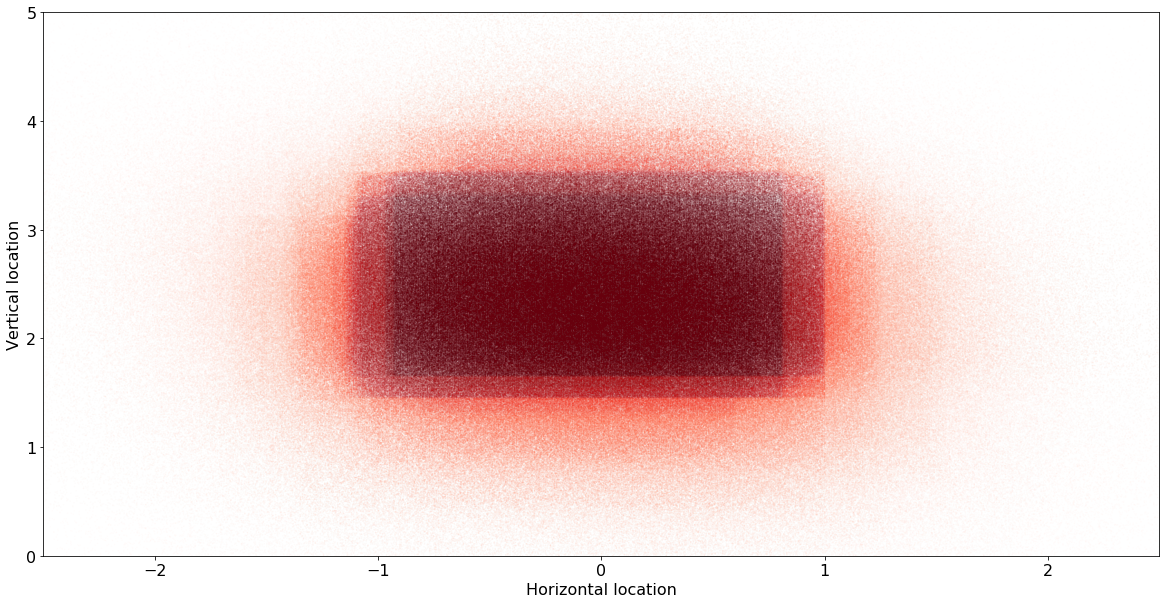

In [75]:
plt.figure(figsize=(20,10))
plt.xlim(-2.5,2.5)
plt.ylim(0,5)
plt.scatter(X_test['px'],X_test['pz'],s=.05, c=probs, alpha=0.2, cmap='Reds');
plt.xlabel('Horizontal location',fontsize=16)
plt.ylabel('Vertical location',fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=16)
#plt.legend(('Bad Pitch', 'Good Pitch'), loc='best', fontsize=16)
plt.savefig('predictions_RF_baseline.jpg')

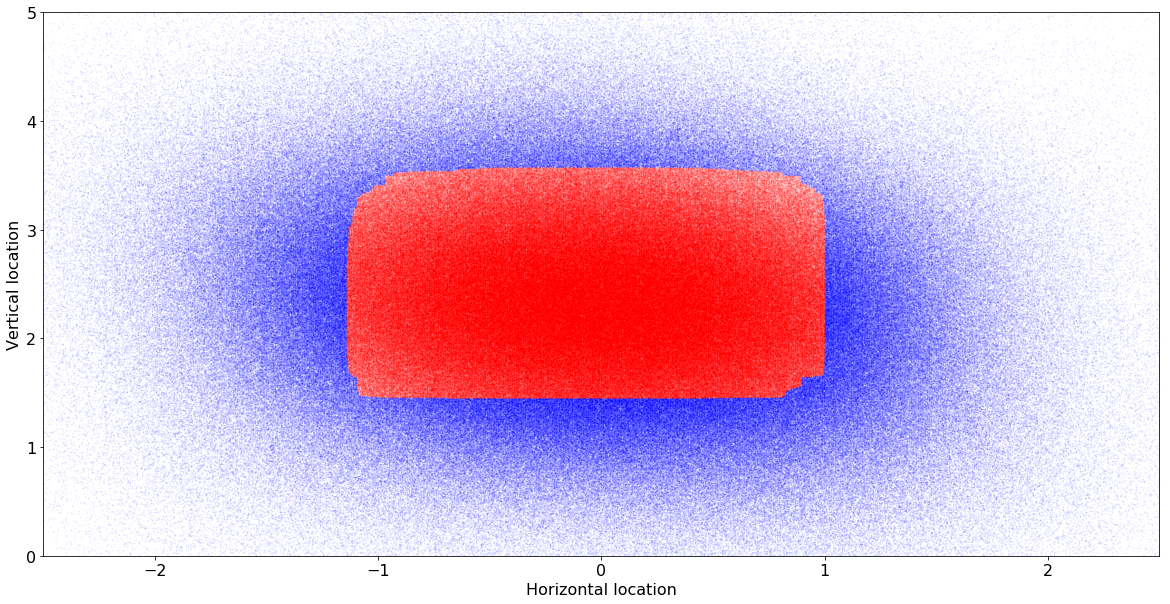

In [77]:
plt.figure(figsize=(20,10))
plt.xlim(-2.5,2.5)
plt.ylim(0,5)
plt.scatter(X_test['px'],X_test['pz'],s=.05, c=preds, alpha=0.2, cmap='bwr');
plt.xlabel('Horizontal location',fontsize=16)
plt.ylabel('Vertical location',fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=16)
#plt.legend(('Bad Pitch', 'Good Pitch'), loc='best', fontsize=16)
plt.savefig('preds_class_RF_baseline.jpg')